# Initial Setup 

In [333]:
import pandas as pd 
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [624]:
df = pd.read_csv("../raw_data/data/BDI/cleaned_daily_BDI.csv")

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

df.head(2)

,Price
Date,
1995-01-03,1964.0
1995-01-04,1961.0


# Scaling the dataset & manual Holdout method

### Holdout method

Train/val/test split = (7:2:1)

In [625]:
input_length = len(df)

In [626]:
def train_test_split(df:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> tuple:
    '''
    Returns a train dataframe and a test dataframe (df_train, df_test)
    from which one can sample (X,y) sequences using TimeseriesGenerator.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET

    last_train_idx = round(train_test_ratio * len(df))
    df_train = df.iloc[0:last_train_idx, :]

    # TEST SET
 
    first_test_idx = last_train_idx - input_length
    df_test = df.iloc[first_test_idx:, :]

    return (df_train, df_test)

In [627]:
df_train, df_test = train_test_split(df=df, train_test_ratio=0.8, input_length=input_length)

In [628]:
len(df_train)

4000

In [629]:
len(df_test)

1000

# TimeseriesGenerator for sequences

In [630]:
X_train = df_train
y_train = df_train["Price"]

X_test  = df_test
y_test = df_test["Price"]

In [631]:
scaler = MinMaxScaler()

In [577]:
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)


In [578]:
# y_train_scaled = scaler.fit_transform(y_train)
# y_test_scaled = scaler.fit_transform(y_test)

In [673]:
generator = TimeseriesGenerator(X_train, y_train, length=7, batch_size=6, sampling_rate=1, stride=1)

In [674]:
generator_val = TimeseriesGenerator(X_test, y_test, length=7, batch_size=6, sampling_rate=1, stride=1)

In [675]:
for X, y in generator:
    print(X.shape, y.shape)
    print(X[0], y[0])
    break

(6, 7, 1) (6,)
[[1964.]
 [1961.]
 [1967.]
 [1983.]
 [1994.]
 [2015.]
 [2019.]] 2038.0


# The model

In [676]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [677]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)

In [851]:
rmsprop = RMSprop(learning_rate=0.0001)
adam = Adam(learning_rate=0.01)

In [852]:
def init_model():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(400, activation="tanh", input_shape=(7,1), return_sequences=False))

    #Dense layers
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

# Training & Testing 

In [701]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_mae", patience=30, restore_best_weights=True)

In [702]:
model = init_model()

In [703]:
history = model.fit(
    generator, epochs=100, validation_data=generator_val, shuffle=True, callbacks=es
)

Epoch 1/100
666/666 [==============================] - 10s 12ms/step - loss: 8603959.0000 - mae: 2003.0972 - val_loss: 402097.9062 - val_mae: 569.8585
Epoch 2/100
666/666 [==============================] - 7s 11ms/step - loss: 4623577.0000 - mae: 1382.0402 - val_loss: 1108157.6250 - val_mae: 980.6452
Epoch 3/100
666/666 [==============================] - 7s 11ms/step - loss: 3619362.2500 - mae: 1210.1147 - val_loss: 768201.5000 - val_mae: 814.6632
Epoch 4/100
666/666 [==============================] - 7s 11ms/step - loss: 2745729.0000 - mae: 969.1602 - val_loss: 588612.8125 - val_mae: 687.8508
Epoch 5/100
666/666 [==============================] - 7s 10ms/step - loss: 1963908.7500 - mae: 749.5281 - val_loss: 285627.0625 - val_mae: 459.9814
Epoch 6/100
666/666 [==============================] - 7s 10ms/step - loss: 1400211.5000 - mae: 598.0226 - val_loss: 127928.5391 - val_mae: 305.2206
Epoch 7/100
666/666 [==============================] - 7s 11ms/step - loss: 1225997.7500 - mae: 482.0

666/666 [==============================] - 8s 11ms/step - loss: 279657.7812 - mae: 291.5478 - val_loss: 10822.7705 - val_mae: 80.9403
Epoch 57/100
666/666 [==============================] - 7s 11ms/step - loss: 310677.7812 - mae: 288.3050 - val_loss: 25561.8906 - val_mae: 124.3749
Epoch 58/100
666/666 [==============================] - 8s 11ms/step - loss: 365907.1875 - mae: 317.2220 - val_loss: 19507.7051 - val_mae: 112.5691
Epoch 59/100
666/666 [==============================] - 7s 10ms/step - loss: 362435.5938 - mae: 315.6026 - val_loss: 18281.5703 - val_mae: 94.3517
Epoch 60/100
666/666 [==============================] - 7s 11ms/step - loss: 308090.1875 - mae: 296.2497 - val_loss: 71370.3047 - val_mae: 204.2868
Epoch 61/100
666/666 [==============================] - 7s 11ms/step - loss: 257722.4688 - mae: 279.2150 - val_loss: 22501.8848 - val_mae: 96.4797
Epoch 62/100
666/666 [==============================] - 7s 10ms/step - loss: 309606.1250 - mae: 309.9362 - val_loss: 14198.5283 

In [694]:
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_62 (LSTM)              (None, 400)               643200    
                                                                 
 dense_100 (Dense)           (None, 128)               51328     
                                                                 
 dense_101 (Dense)           (None, 1)                 129       
                                                                 
Total params: 694,657
Trainable params: 694,657
Non-trainable params: 0
_________________________________________________________________


array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

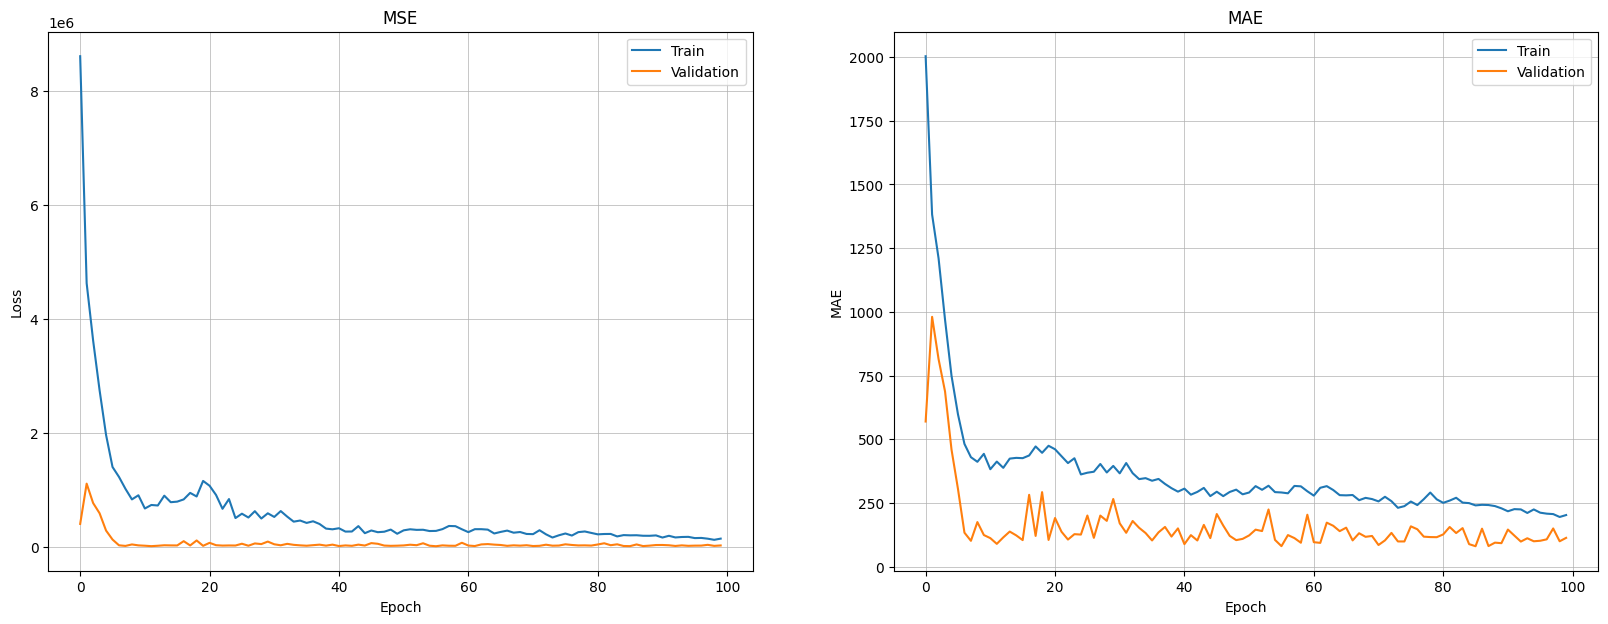

In [718]:
plot_history(history)

# Setup code for learning curves

In [686]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

In [705]:
model.save("univariate model")

INFO:tensorflow:Assets written to: univariate model/assets


INFO:tensorflow:Assets written to: univariate model/assets


In [708]:
history.params


{'verbose': 1, 'epochs': 100, 'steps': 666}

In [732]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [734]:
min(history.history["mae"])

195.4354705810547

In [736]:
min(history.history["val_mae"])

80.67047882080078

# Second Training!

In [ ]:
generator2 = TimeseriesGenerator(X_train,
                                 y_train,
                                 length=14,
                                 batch_size=16,
                                 sampling_rate=1,
                                 stride=1,
                                 shuffle=False)

In [ ]:
generator_val2 = TimeseriesGenerator(X_test,
                                     y_test,
                                     length=14, 
                                     batch_size=16,
                                     sampling_rate=1,
                                     stride=1,
                                     shuffle=False)

In [ ]:
len(generator2)

In [ ]:
for X, y in generator2:
    print(X.shape, y.shape)
    print(X[0], y[0])
    break

In [853]:
def init_model2():
    
    model = Sequential()

    #LSTM layers
    model.add(layers.LSTM(250, activation="tanh", input_shape=(14,1), return_sequences=True))

    #Dense layers
    model.add(layers.Dense(150, activation="relu"))
    model.add(layers.Dense(1, activation="linear"))

    #compiling model
    model.compile(loss="mse", optimizer=rmsprop, metrics="mae")
    
    return model

In [854]:
model2 = init_model2()

Input length, two weeks <br>
predict one week into the future.

In [855]:
es2 = EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)

In [856]:
history2 = model2.fit(generator2, epochs=100, validation_data=generator_val2, shuffle=False, callbacks=es2)

Epoch 1/100
250/250 [==============================] - 5s 13ms/step - loss: 11836295.0000 - mae: 2690.2463 - val_loss: 1542936.5000 - val_mae: 1180.1737
Epoch 2/100
250/250 [==============================] - 3s 11ms/step - loss: 11734486.0000 - mae: 2672.4521 - val_loss: 1491550.7500 - val_mae: 1158.1934
Epoch 3/100
250/250 [==============================] - 3s 12ms/step - loss: 11590677.0000 - mae: 2646.4683 - val_loss: 1423215.8750 - val_mae: 1128.3029
Epoch 4/100
250/250 [==============================] - 3s 12ms/step - loss: 11396777.0000 - mae: 2611.1392 - val_loss: 1333289.8750 - val_mae: 1087.7198
Epoch 5/100
250/250 [==============================] - 3s 12ms/step - loss: 11165666.0000 - mae: 2567.5310 - val_loss: 1232284.7500 - val_mae: 1040.2334
Epoch 6/100
250/250 [==============================] - 3s 12ms/step - loss: 10896051.0000 - mae: 2515.6353 - val_loss: 1119292.2500 - val_mae: 984.3724
Epoch 7/100
250/250 [==============================] - 3s 12ms/step - loss: 1059579

array([<AxesSubplot: title={'center': 'MSE'}, xlabel='Epoch', ylabel='Loss'>,
       <AxesSubplot: title={'center': 'MAE'}, xlabel='Epoch', ylabel='MAE'>],
      dtype=object)

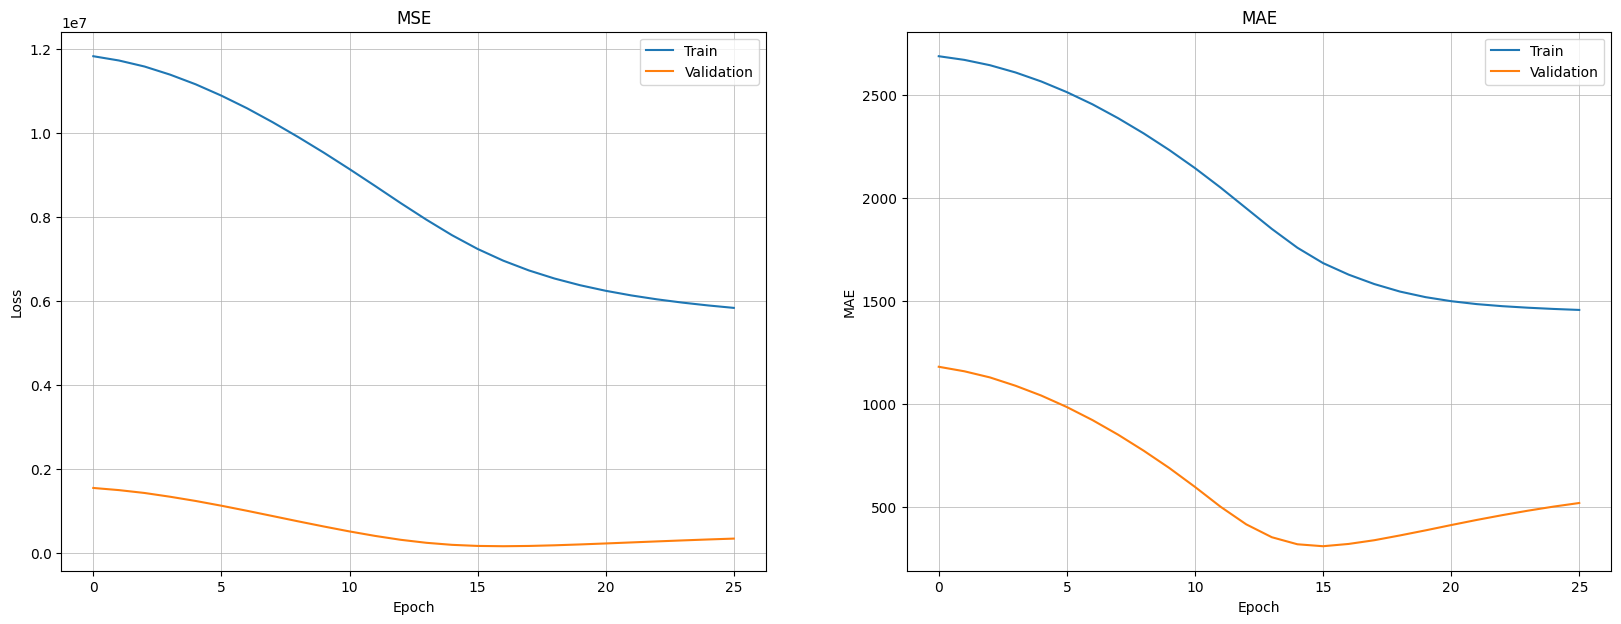

In [857]:
plot_history(history2)